In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import io
import os
import pathlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist
from bioinfokit.visuz import cluster

############################################
############### Parsing dati ###############

#Lettura dati da dataset
path = str(pathlib.Path().absolute())
path_low_lev = path + "/prova1_low_level_post.txt"


df_low = pd.read_csv(path_low_lev, skiprows=[0,2,3], delimiter=r"\s+")

df_low = df_low.drop(df_low.tail(8).index)

# PCA LOW LEVEL

In [2]:
df_low

,r,b,swpd,free,buff,cache,si,so,bi,bo,in,cs,us,sy,id,wa,st
0,0,0,5164,100236,119780,972984,0,0,0,4,168,441,4,0,96,0,0
1,0,0,5164,100236,119788,972976,0,0,0,628,147,364,3,0,96,1,0
2,0,0,5164,100236,119788,972988,0,0,0,4,169,376,2,1,97,0,0
3,0,0,5164,100236,119788,972988,0,0,0,4,283,428,2,3,95,0,0
4,0,0,5164,100236,119788,972988,0,0,0,4,433,406,4,3,93,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,0,5164,89924,120336,973520,0,0,20,4,279,390,7,3,90,0,0
296,0,0,5164,89924,120336,973520,0,0,20,4,130,312,1,0,99,0,0
297,0,0,5164,89924,120344,973524,0,0,20,56,482,395,3,5,91,1,0
298,0,0,5164,89924,120344,973528,0,0,20,4,208,325,2,0,98,0,0


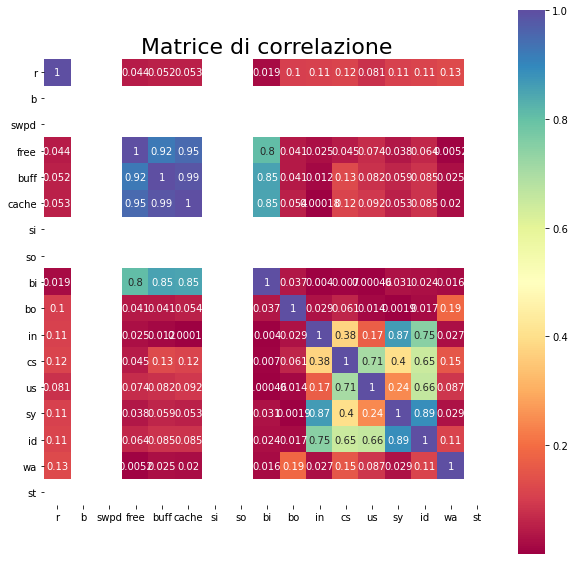

In [3]:
corrMatrix = df_low.corr()
plt.figure(figsize = (10, 10))
plt.title('Matrice di correlazione', size=22)
sn.heatmap(abs(corrMatrix), annot=True, cmap='Spectral', square=True)
plt.show();

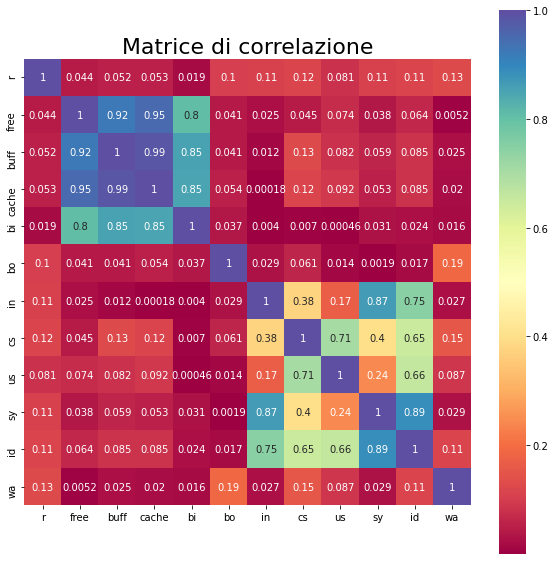

In [4]:
df_low.drop(columns=['b', 'swpd', 'si', 'so', 'st'], inplace=True)

corrMatrix = df_low.corr()
plt.figure(figsize = (10, 10))
plt.title('Matrice di correlazione', size=22)
sn.heatmap(abs(corrMatrix), annot=True, cmap='Spectral', square=True)
plt.show();

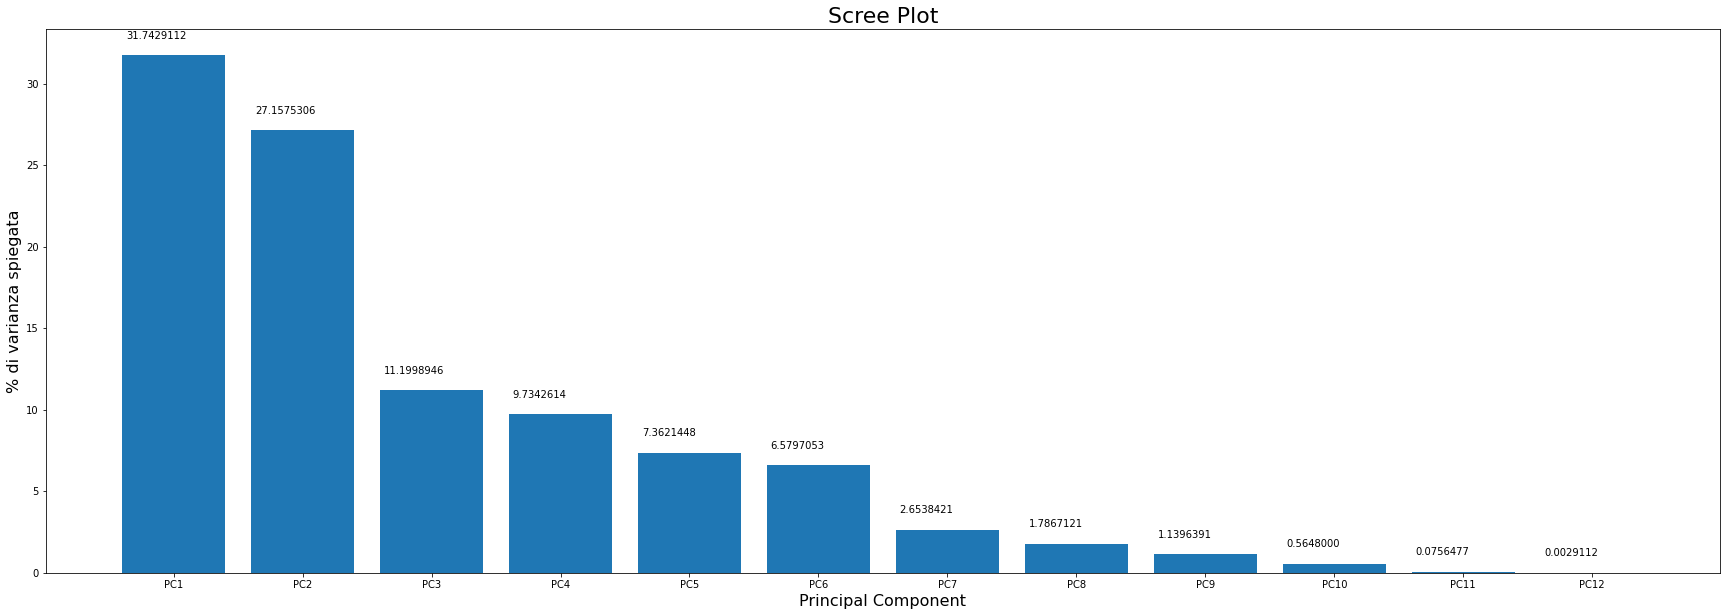

In [5]:
# Normalizzazione Z-score
x = StandardScaler().fit_transform(df_low)
scaled_df = pd.DataFrame(x)


##############################################
################# PCA ########################

pca = PCA() #modello
pca.fit(scaled_df) #aggiunta dataset
pca_data = pca.transform(scaled_df) #creazione 

#Calcolo percentuali di varianza spiegata per ogni PCi
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=7)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

# Definizione PCA dataframe
pca_df = pd.DataFrame(pca_data, columns=labels)

plt.figure(figsize = (30, 10))
plt.ylabel('% di varianza spiegata', size=16)
plt.xlabel('Principal Component', size=16)
plt.title('Scree Plot', size=22)
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels, align='center')
# Annotazione percentuali
i = 1; j = 1
for i in range(len(per_var)):
    plt.annotate('{:.7f}'.format(per_var[i]), (i+0.63, per_var[i] + j))
plt.show()

#Autovalori
eigenvalues = pca.explained_variance_

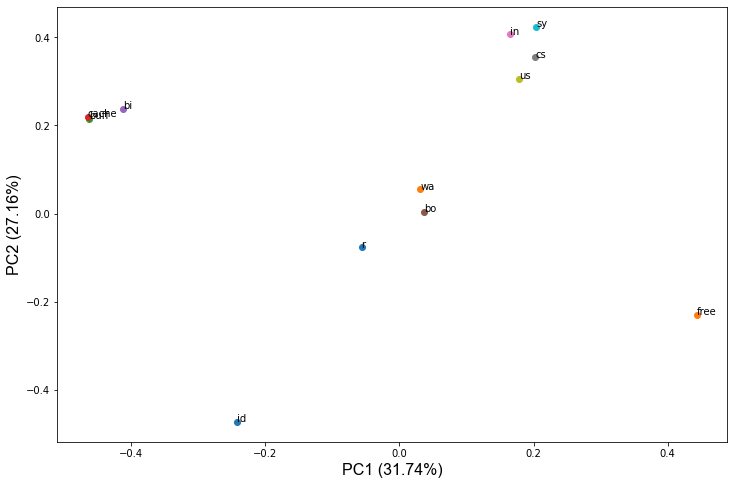

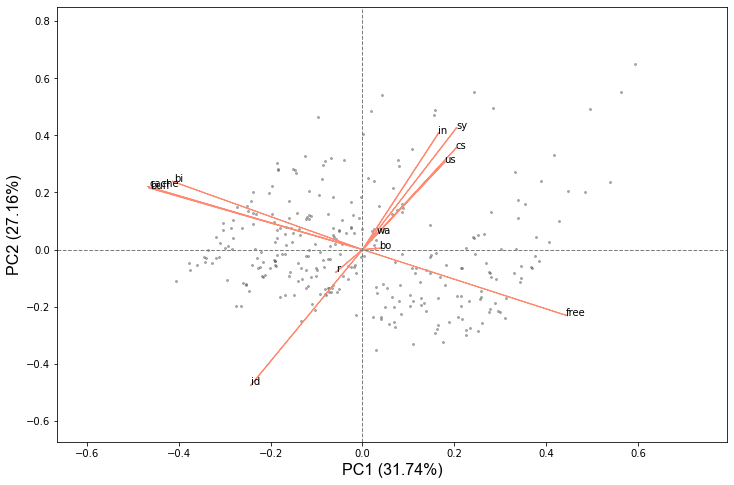

In [6]:
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df_low.columns.values
loadings_df = loadings_df.set_index('variable')

cluster.pcaplot(x=loadings[0], y=loadings[1], labels=df_low.columns.values, var1=round(pca.explained_variance_ratio_[0]*100, 2), var2=round(pca.explained_variance_ratio_[1]*100, 2), axlabelfontsize=16, dim = (12,8), show=True) # plotlabels= False
cluster.biplot(cscore=pca_data, loadings=loadings, labels=df_low.columns.values, var1=round(pca.explained_variance_ratio_[0]*100, 2), var2=round(pca.explained_variance_ratio_[1]*100, 2), axlabelfontsize=16, dim = (12,8), valphadot = 0.4, dotsize = 4, show=True)

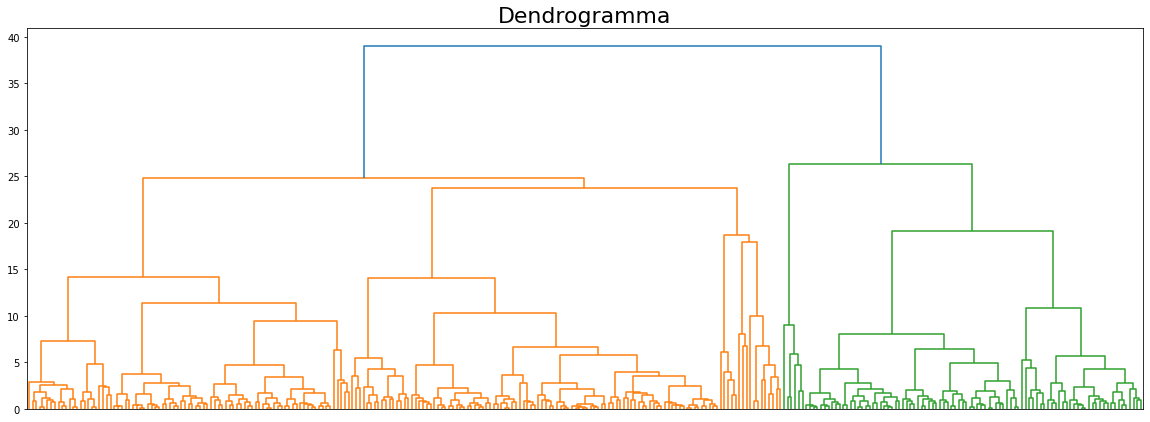

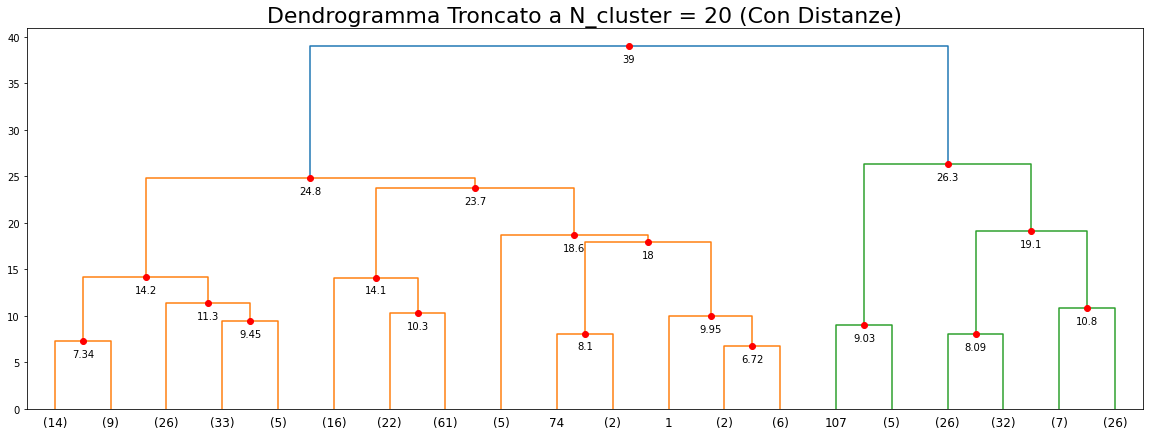

In [7]:
pca89_df = pca_df[pca_df.columns[0:6]]


#Calcolo devianza spiegata dalla PCA 
dev_pca = ((pca89_df - pca89_df.mean(axis=0))**2).values.sum()
#Calcolo devianza totale del modello
dev_tot = ((scaled_df - scaled_df.mean(axis=0))**2).values.sum()
#dev_pca_perc2 = dev_pca/dev_tot #più precisa
#Calcolo devianza percentuale spiegata dalla PCA
dev_pca_percentuale = per_var[0:6].sum()/100

linkage_matrix = sch.linkage(pca89_df, method  = "ward")

plt.figure(figsize = (20, 7))
dendrogram = sch.dendrogram(linkage_matrix, no_labels='true')
plt.title('Dendrogramma', size=22)
plt.xlabel('')
plt.ylabel('')
plt.show()

def augmented_dendrogram(*args, **kwargs):

    ddata = sch.dendrogram(*args, **kwargs)
    distanze = []
    if not kwargs.get('no_plot', False):
        for i, d in zip(ddata['icoord'], ddata['dcoord']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            distanze.append(y)
            plt.plot(x, y, 'ro')
            plt.annotate("%.3g" % y, (x, y), xytext=(0, -8),
                         textcoords='offset points',
                         va='top', ha='center')
    distanze.sort(reverse=True)
    return ddata, distanze

p = 20

plt.figure(figsize = (20, 7))
_, distanze = augmented_dendrogram(linkage_matrix, p, truncate_mode='lastp')
plt.title('Dendrogramma Troncato a N_cluster = 20 (Con Distanze)', size=22)
plt.xlabel('')
plt.ylabel('')
plt.show();

distance_table= pd.DataFrame()
distance_table['Numero cluster'] = range(1,p)
distance_table['Distanza'] = distanze

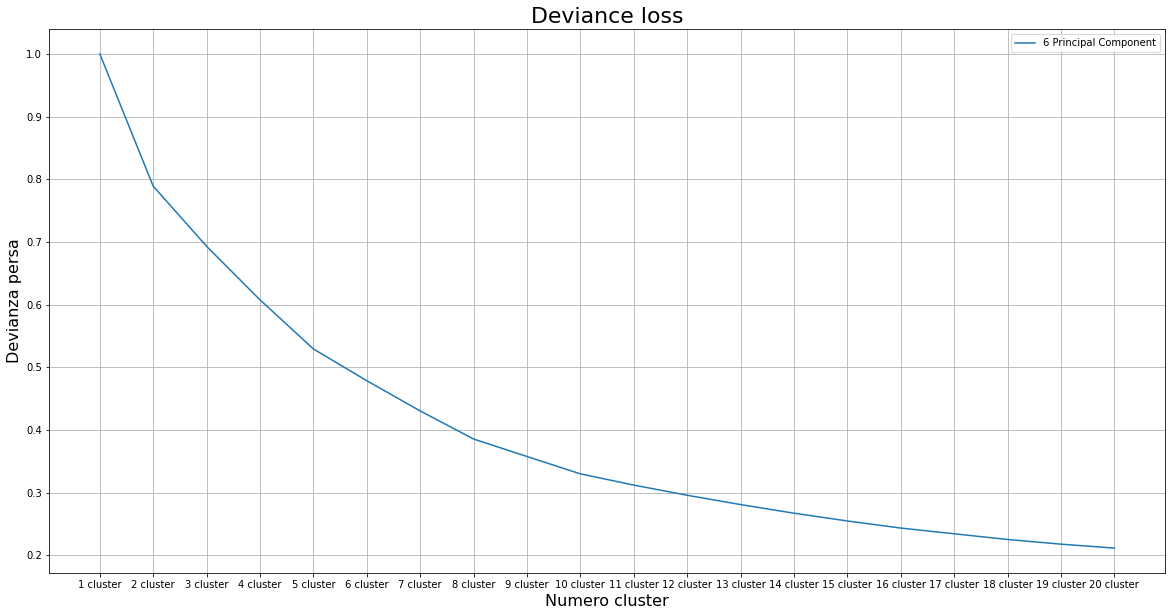

In [8]:
pca_df_dict={}

scelta_cluster_dict={}

cluster_df_dict={}

#Calcolo devianza totale del modello
dev_tot = ((scaled_df - scaled_df.mean(axis=0))**2).values.sum()

#Calcolo dimensione totale DATASET di partenza
dim_tot = scaled_df.size

k = 6 # numero pca

numero_cluster = 20;


pca_df_dict[k] = pd.DataFrame(pca_df[pca_df.columns[0:k]])


#Calcolo devianza spiegata dalla PCA 
dev_pca = ((pca_df_dict[k] - pca_df_dict[k].mean(axis=0))**2).values.sum()
#dev_pca_perc2 = dev_pca/dev_tot #più precisa
#Calcolo devianza percentuale spiegata dalla PCA
dev_pca_percentuale = per_var[0:k+1].sum()/100

linkage_matrix = sch.linkage(pca_df_dict[k], method  = "ward")


cluster_df = pd.DataFrame()

scelta_cluster_dict[k] = pd.DataFrame(columns=["N cluster", "dev_loss", "dev_rimasta", "dim_ratio"])

for p in range(1,numero_cluster+1):
    array_dist = fcluster(linkage_matrix, p, criterion='maxclust')
    col_label = str(p)+" cluster"
    cluster_df[col_label]=array_dist



cluster_df_dict[k] = cluster_df

for cont,i in enumerate(cluster_df.columns, 1):
    dev_intra = 0; dev_inter = 0

    gruppi = cluster_df[i].groupby(cluster_df[i])
    for gr in range(1,max(cluster_df[i])+1):
        gruppetto = pd.DataFrame(gruppi.get_group(gr))
        gruppetto = gruppetto.join(pca_df_dict[k])
        gruppetto = gruppetto.drop(columns=[i])
        centroid = gruppetto.mean(axis = 0)
        centroid = centroid.to_numpy()
        dev_intra = dev_intra + ((gruppetto-centroid)**2).values.sum()
        dev_inter = dev_inter + len(gruppetto)*(((centroid-pca_df_dict[k].mean(axis=0))**2).values.sum())


    dev_lost_percentuale = (1 - dev_pca/dev_tot)+(dev_intra/dev_tot)
    dev_pca_cl_per = dev_inter/dev_tot
    dim_ratio =  (cont * k) / dim_tot

#         print((dev_intra + dev_inter)/dev_pca)

    new_row = {'N cluster':i, 'dev_loss':dev_lost_percentuale, 'dev_rimasta':dev_pca_cl_per, 'dim_ratio':dim_ratio}
    scelta_cluster_dict[k] = scelta_cluster_dict[k].append(new_row, ignore_index=True)


plt.figure(figsize = (20, 10))

plt.plot(scelta_cluster_dict[k]["N cluster"], scelta_cluster_dict[k]["dev_loss"], label='{} Principal Component'.format(k))
plt.legend(loc='upper right')
plt.title('Deviance loss', size=22)
plt.xlabel('Numero cluster', size=16)
plt.ylabel('Devianza persa', size=16)
plt.grid()
plt.show()

In [9]:
scelta_cluster_dict[6]

,N cluster,dev_loss,dev_rimasta,dim_ratio
0,1 cluster,1.000000,0.000000,0.001667
1,2 cluster,0.788968,0.211032,0.003333
2,3 cluster,0.693030,0.306970,0.005000
3,4 cluster,0.607600,0.392400,0.006667
4,5 cluster,0.529261,0.470739,0.008333
5,6 cluster,0.478604,0.521396,0.010000
6,7 cluster,0.430313,0.569687,0.011667
7,8 cluster,0.385537,0.614463,0.013333
8,9 cluster,0.357630,0.642370,0.015000
9,10 cluster,0.329929,0.670071,0.016667


# Direi 9 clusters

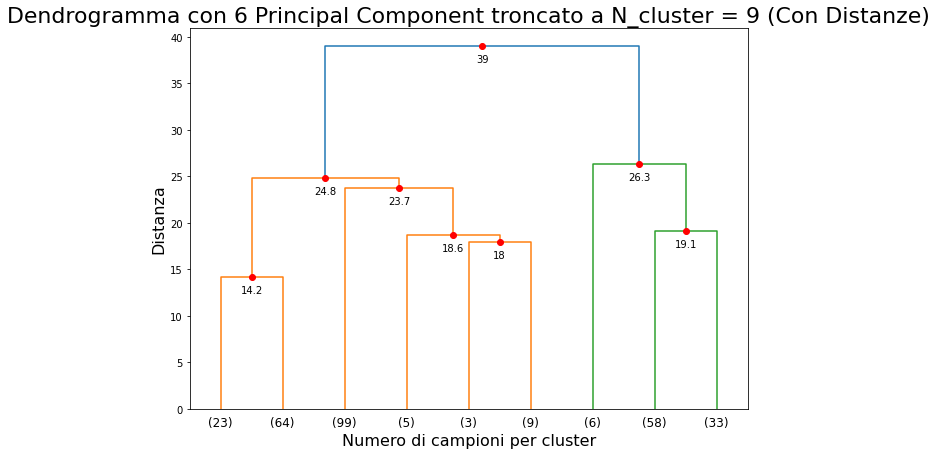

   Numero cluster   Distanza
0               1  38.979863
1               2  26.282267
2               3  24.801051
3               4  23.749618
4               5  19.097840
5               6  18.646679
6               7  17.955025
7               8  14.175101


In [10]:
linkage_matrix = sch.linkage(pca_df_dict[k], method  = "ward")
plt.figure(figsize = (10, 7))
_, distanze = augmented_dendrogram(linkage_matrix, 9, truncate_mode='lastp')
plt.title('Dendrogramma con 6 Principal Component troncato a N_cluster = 9 (Con Distanze)', size=22)
plt.xlabel('Numero di campioni per cluster', size = 16)
plt.ylabel('Distanza', size = 16)
plt.show();

distance_table= pd.DataFrame()
distance_table['Numero cluster'] = range(1,9)
distance_table['Distanza'] = distanze

print(distance_table)

In [11]:
df_low["9_cluster"] = cluster_df_dict[k]["9 cluster"]

grs = df_low.groupby("9_cluster")

# print(df_low.size_group.value_counts())

index_list = []

for g in grs:
    sample=grs.get_group(g[0]).sample(random_state=42)
    print(sample)
    index_list.append(sample.index[0])
    
synt_workload_low = pca_df_dict[k][pca_df_dict[k].index.isin(index_list)]
synt_workload_low

     r   free    buff   cache  bi  bo   in   cs  us  sy  id  wa  9_cluster
252  0  90752  120272  973464  20   4  460  416   3   6  91   0          1
     r   free    buff   cache  bi  bo   in   cs  us  sy  id  wa  9_cluster
258  0  90248  120280  973468  24   4  230  364   4   1  95   0          2
     r   free    buff   cache  bi  bo   in   cs  us  sy  id  wa  9_cluster
214  0  91760  120192  973400  16   4  204  377   4   1  95   0          3
     r   free    buff   cache  bi  bo   in   cs  us  sy  id  wa  9_cluster
135  0  93524  120060  973284   8  56  474  423   3   4  92   1          4
    r   free    buff   cache  bi  bo   in   cs  us  sy  id  wa  9_cluster
74  4  97100  119940  973152   8  80  201  371   2   1  96   1          5
     r   free    buff   cache  bi   bo   in   cs  us  sy  id  wa  9_cluster
216  0  91760  120200  973400  16  548  206  359   1   1  98   0          6
    r   free    buff   cache  bi  bo   in   cs  us  sy  id  wa  9_cluster
13  0  99984  119804  9730

,PC1,PC2,PC3,PC4,PC5,PC6
0,2.816663,-2.233370,0.611603,1.655813,0.199630,-0.170455
13,5.081099,2.398839,1.878305,3.325689,0.868442,-0.954178
72,2.632998,1.347167,-0.781086,-0.240281,0.298259,0.089706
74,0.463146,-2.034854,6.597546,-4.456411,5.109024,2.380107
135,0.829748,1.474295,3.322578,-1.585179,-0.788004,4.573926
214,-1.569893,0.175000,0.403014,1.301892,0.083918,-0.144797
216,-2.037880,-0.985333,2.404901,-2.311644,-3.889940,-2.904449
252,-1.364026,2.713077,-0.678999,-0.226286,0.064432,0.150161
258,-2.692320,0.774976,0.379712,1.273902,0.009397,-0.138233


In [12]:
synt_workload_low.to_csv("synt_wl_low_post.csv", index_label='id')